# Libraries

In [15]:
from fastai.vision.all import *

# Run

In [16]:
def iou_multi(inp, targ):
    "Calcula o IoU para segmentação multiclasse"
    # Converte as predições para a classe vencedora (argmax)
    inp = inp.argmax(dim=1)
    targ = targ.squeeze(1)
    
    ious = []
    # Loop por cada classe (exceto void se tiver)
    for c in range(dls.c): 
        # Interseção: onde os dois dizem que é a classe C
        intersection = ((inp == c) & (targ == c)).float().sum()
        # União: onde pelo menos um diz que é a classe C
        union = ((inp == c) | (targ == c)).float().sum()
        
        if union > 0:
            ious.append(intersection / union)
    
    # Retorna a média dos IoUs de todas as classes
    return torch.tensor(ious).mean()

[0, 2.7226009368896484, 2.7230913639068604, 0.20476074516773224, 6.685881784200656, 0.013380694203078747, '00:15']
[0, 2.1299171447753906, 1.8852638006210327, 0.4422973692417145, 17.08462740812587, 0.06267266720533371, '00:16']
[1, 1.8470935821533203, 1.3842651844024658, 0.606677234172821, 14.702558191763444, 0.10676832497119904, '00:16']
[2, 1.6244245767593384, 1.2646803855895996, 0.6196126341819763, 15.153727256255195, 0.09648694097995758, '00:16']
[3, 1.4593232870101929, 1.2163821458816528, 0.6338907480239868, 15.981139842645815, 0.11606446653604507, '00:16']
[4, 1.3451812267303467, 1.1877779960632324, 0.6513060927391052, 15.83414385009338, 0.12628193199634552, '00:16']
[5, 1.2535029649734497, 0.8677909970283508, 0.7642903923988342, 18.048201237028344, 0.18449464440345764, '00:16']
[6, 1.1482326984405518, 0.7637728452682495, 0.7899820804595947, 18.128189817312045, 0.18986402451992035, '00:16']
[7, 1.0466997623443604, 0.7340577840805054, 0.799511730670929, 18.307027800632053, 0.20205

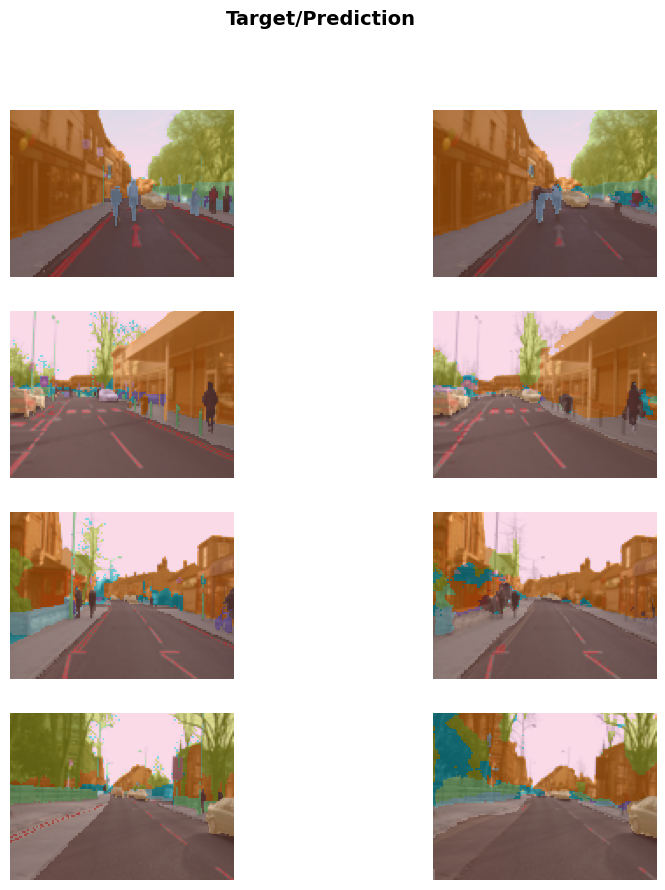

In [17]:
from fastai.vision.all import *

# --- 1. Preparação (Igual ao anterior) ---
path = untar_data(URLs.CAMVID_TINY)

def label_func(fn): 
    return path/'labels'/f'{fn.stem}_P{fn.suffix}'

# --- 2. Correção das Métricas ---

# Acurácia corrigida para Segmentação (Olha o eixo 1)
def acc_camvid(inp, targ):
    return accuracy(inp, targ, axis=1)

# Definição do IoU Multiclasse (para garantir que existe)
def iou_multi(inp, targ):
    inp = inp.argmax(dim=1)
    targ = targ.squeeze(1)
    ious = []
    # Ignora o código 30 (Void) se existir, mas vamos fazer simples para todas as classes
    for c in range(inp.max()+1): 
        intersection = ((inp == c) & (targ == c)).float().sum()
        union = ((inp == c) | (targ == c)).float().sum()
        if union > 0: ious.append(intersection / union)
    return torch.tensor(ious).mean()

# --- 3. Dataloaders ---
dls = SegmentationDataLoaders.from_label_func(
    path, 
    bs=8, 
    fnames = get_image_files(path/'images'),
    label_func = label_func,
    codes = np.loadtxt(path/'codes.txt', dtype=str),
    valid_pct=0.2,
    seed=42
)

# --- 4. Modelo com as métricas certas ---
# Note: Usamos 'acc_camvid' em vez de 'accuracy'
# E usamos Dice() instanciado, que já sabe lidar com segmentação melhor que DiceMulti solto
learn = unet_learner(dls, resnet34, metrics=[acc_camvid, Dice, iou_multi])

# --- 5. Treino ---
with learn.no_bar():
    learn.fine_tune(20)

# --- 6. Ver resultado ---
learn.show_results(max_n=4, figsize=(10,10))

In [22]:
# 1. Avisa pro learner que o "caminho de casa" é AQUI (pasta atual)
learn.path = Path('.')

# Salva tudo no arquivo 'meu_modelo.pkl'
learn.export('meu_modelo.pkl')

print("Modelo salvo com sucesso!")

Modelo salvo com sucesso!


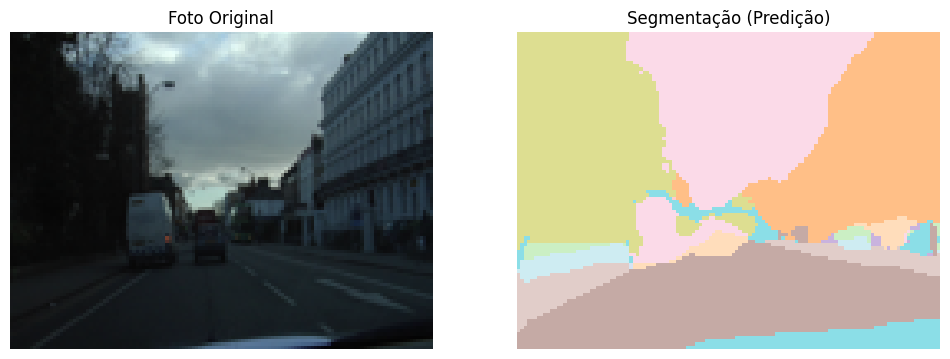

In [25]:
from fastai.vision.all import *
import matplotlib.pyplot as plt

# --- A. Carregar o Modelo (Se você tiver fechado o notebook) ---
# Se você ainda está com o 'learn' na memória, pule essa linha.
# Se abriu um notebook novo, use isso:
learn_inf = load_learner('meu_modelo.pkl')

# --- B. Escolher uma imagem para testar ---
# Vamos pegar uma aleatória do dataset de validação para garantir que funciona
img_path = get_image_files(path/'images')[2]
# OU use uma imagem sua:
# img_path = 'minha_foto_da_rua.jpg'

# --- C. O comando Mágico: Predict ---
# Ele retorna 3 coisas:
# 1. pred_mask: A imagem da máscara já pronta (bonitinha)
# 2. pred_idx: A máscara em números (tensor com 0, 1, 2...)
# 3. probs: As probabilidades de certeza para cada pixel
pred_mask, pred_idx, probs = learn_inf.predict(img_path)

# --- D. Ver o Resultado ---
# Vamos plotar lado a lado: Imagem Original vs O que a IA viu
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Lado Esquerdo: Foto Original
img = PILImage.create(img_path)
img.show(ctx=ax[0], title='Foto Original')

# Lado Direito: O que o modelo pintou
pred_mask.show(ctx=ax[1], title='Segmentação (Predição)')

plt.show()

📂 Arquivo analisado: 0001TP_006750_P.png
📏 Tamanho: (128, 96)
🎨 Modo de cor: L (L = Tons de Cinza/Indexado)
------------------------------
🔍 VALORES ÚNICOS NOS PIXELS:
[ 4  5  6  8 10 12 14 16 17 19 21 22 24 26 27 30]

Isso significa que nesta imagem só existem as classes: [ 4  5  6  8 10 12 14 16 17 19 21 22 24 26 27 30]
------------------------------
📖 DICIONÁRIO (Codes.txt):
Pixel valor 4 = Building
Pixel valor 5 = Car
Pixel valor 6 = CartLuggagePram
Pixel valor 8 = Column_Pole
Pixel valor 10 = LaneMkgsDriv
Pixel valor 12 = Misc_Text
Pixel valor 14 = OtherMoving
Pixel valor 16 = Pedestrian
Pixel valor 17 = Road
Pixel valor 19 = Sidewalk
Pixel valor 21 = Sky
Pixel valor 22 = SUVPickupTruck
Pixel valor 24 = TrafficLight
Pixel valor 26 = Tree
Pixel valor 27 = Truck_Bus
Pixel valor 30 = Void


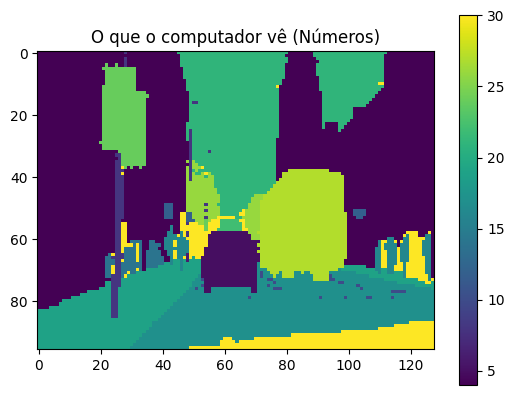

In [27]:
import numpy as np
from PIL import Image

# 1. Vamos pegar UM exemplo de máscara (Gabarito)
mascara_exemplo = get_image_files(path/'labels')[0]
img = Image.open(mascara_exemplo)
dados_pixels = np.array(img)

print(f"📂 Arquivo analisado: {mascara_exemplo.name}")
print(f"📏 Tamanho: {img.size}")
print(f"🎨 Modo de cor: {img.mode} (L = Tons de Cinza/Indexado)")
print("-" * 30)

# 2. O Segredo: O que tem dentro dos pixels?
print("🔍 VALORES ÚNICOS NOS PIXELS:")
unicos = np.unique(dados_pixels)
print(unicos)
print(f"\nIsso significa que nesta imagem só existem as classes: {unicos}")

# 3. Traduzindo os números (codes.txt)
codes = np.loadtxt(path/'codes.txt', dtype=str)
print("-" * 30)
print("📖 DICIONÁRIO (Codes.txt):")
for num in unicos:
    if num < len(codes):
        print(f"Pixel valor {num} = {codes[num]}")
    else:
        print(f"Pixel valor {num} = Void/Ignorado")

# 4. Ver visualmente
import matplotlib.pyplot as plt
plt.imshow(dados_pixels)
plt.colorbar()
plt.title("O que o computador vê (Números)")
plt.show()